In [221]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [314]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [315]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates + ["Delivery_Quarter"], axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [224]:
import catboost as ctb

In [305]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [316]:
prep = preprocess(data)

In [317]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [318]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [319]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [320]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [321]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [322]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6682396	test: 0.6685590	best: 0.6685590 (0)	total: 17.2ms	remaining: 1m 26s
1:	learn: 0.6432077	test: 0.6438456	best: 0.6438456 (1)	total: 34.5ms	remaining: 1m 26s
2:	learn: 0.6199266	test: 0.6209298	best: 0.6209298 (2)	total: 51.5ms	remaining: 1m 25s
3:	learn: 0.5985184	test: 0.5998652	best: 0.5998652 (3)	total: 63.5ms	remaining: 1m 19s
4:	learn: 0.5786127	test: 0.5801909	best: 0.5801909 (4)	total: 73.7ms	remaining: 1m 13s
5:	learn: 0.5607154	test: 0.5625088	best: 0.5625088 (5)	total: 80.3ms	remaining: 1m 6s
6:	learn: 0.5407816	test: 0.5428202	best: 0.5428202 (6)	total: 96.1ms	remaining: 1m 8s
7:	learn: 0.5218315	test: 0.5241180	best: 0.5241180 (7)	total: 112ms	remaining: 1m 9s
8:	learn: 0.5055824	test: 0.5080957	best: 0.5080957 (8)	total: 128ms	remaining: 1m 10s
9:	learn: 0.4908039	test: 0.4935672	best: 0.4935672 (9)	total: 142ms	remaining: 1m 10s
10:	learn: 0.4763828	test: 0.4793251	best: 0.4793251 (10)	total: 148ms	remaining: 1m 7s
11:	learn: 0.4595847	test: 0.4627912	b

93:	learn: 0.1250128	test: 0.1359058	best: 0.1359058 (93)	total: 1.5s	remaining: 1m 18s
94:	learn: 0.1240268	test: 0.1349763	best: 0.1349763 (94)	total: 1.52s	remaining: 1m 18s
95:	learn: 0.1234120	test: 0.1344224	best: 0.1344224 (95)	total: 1.54s	remaining: 1m 18s
96:	learn: 0.1225910	test: 0.1336818	best: 0.1336818 (96)	total: 1.55s	remaining: 1m 18s
97:	learn: 0.1219001	test: 0.1330200	best: 0.1330200 (97)	total: 1.57s	remaining: 1m 18s
98:	learn: 0.1212480	test: 0.1323992	best: 0.1323992 (98)	total: 1.59s	remaining: 1m 18s
99:	learn: 0.1205290	test: 0.1317201	best: 0.1317201 (99)	total: 1.61s	remaining: 1m 18s
100:	learn: 0.1196705	test: 0.1309609	best: 0.1309609 (100)	total: 1.63s	remaining: 1m 18s
101:	learn: 0.1187498	test: 0.1301193	best: 0.1301193 (101)	total: 1.65s	remaining: 1m 19s
102:	learn: 0.1181687	test: 0.1295870	best: 0.1295870 (102)	total: 1.66s	remaining: 1m 19s
103:	learn: 0.1177111	test: 0.1291590	best: 0.1291590 (103)	total: 1.68s	remaining: 1m 19s
104:	learn: 0.

187:	learn: 0.0908457	test: 0.1055735	best: 0.1055735 (187)	total: 3.16s	remaining: 1m 20s
188:	learn: 0.0906894	test: 0.1054713	best: 0.1054713 (188)	total: 3.18s	remaining: 1m 21s
189:	learn: 0.0904997	test: 0.1052946	best: 0.1052946 (189)	total: 3.2s	remaining: 1m 21s
190:	learn: 0.0902661	test: 0.1050948	best: 0.1050948 (190)	total: 3.22s	remaining: 1m 20s
191:	learn: 0.0901398	test: 0.1049728	best: 0.1049728 (191)	total: 3.23s	remaining: 1m 20s
192:	learn: 0.0899734	test: 0.1048135	best: 0.1048135 (192)	total: 3.25s	remaining: 1m 21s
193:	learn: 0.0897519	test: 0.1045860	best: 0.1045860 (193)	total: 3.27s	remaining: 1m 20s
194:	learn: 0.0896077	test: 0.1044269	best: 0.1044269 (194)	total: 3.28s	remaining: 1m 20s
195:	learn: 0.0892736	test: 0.1040851	best: 0.1040851 (195)	total: 3.3s	remaining: 1m 20s
196:	learn: 0.0890410	test: 0.1038996	best: 0.1038996 (196)	total: 3.32s	remaining: 1m 20s
197:	learn: 0.0889370	test: 0.1038000	best: 0.1038000 (197)	total: 3.33s	remaining: 1m 20s
1

283:	learn: 0.0774036	test: 0.0949436	best: 0.0949436 (283)	total: 4.86s	remaining: 1m 20s
284:	learn: 0.0773356	test: 0.0948678	best: 0.0948678 (284)	total: 4.88s	remaining: 1m 20s
285:	learn: 0.0771011	test: 0.0947371	best: 0.0947371 (285)	total: 4.89s	remaining: 1m 20s
286:	learn: 0.0769496	test: 0.0946367	best: 0.0946367 (286)	total: 4.91s	remaining: 1m 20s
287:	learn: 0.0768078	test: 0.0944856	best: 0.0944856 (287)	total: 4.93s	remaining: 1m 20s
288:	learn: 0.0767696	test: 0.0944425	best: 0.0944425 (288)	total: 4.94s	remaining: 1m 20s
289:	learn: 0.0767058	test: 0.0944058	best: 0.0944058 (289)	total: 4.96s	remaining: 1m 20s
290:	learn: 0.0766397	test: 0.0943741	best: 0.0943741 (290)	total: 4.97s	remaining: 1m 20s
291:	learn: 0.0764814	test: 0.0943091	best: 0.0943091 (291)	total: 4.99s	remaining: 1m 20s
292:	learn: 0.0764795	test: 0.0943074	best: 0.0943074 (292)	total: 5s	remaining: 1m 20s
293:	learn: 0.0763288	test: 0.0941963	best: 0.0941963 (293)	total: 5.02s	remaining: 1m 20s
29

381:	learn: 0.0687586	test: 0.0890148	best: 0.0890148 (381)	total: 6.52s	remaining: 1m 18s
382:	learn: 0.0685927	test: 0.0889674	best: 0.0889674 (382)	total: 6.54s	remaining: 1m 18s
383:	learn: 0.0685145	test: 0.0889432	best: 0.0889432 (383)	total: 6.56s	remaining: 1m 18s
384:	learn: 0.0684629	test: 0.0889293	best: 0.0889293 (384)	total: 6.58s	remaining: 1m 18s
385:	learn: 0.0684253	test: 0.0889002	best: 0.0889002 (385)	total: 6.58s	remaining: 1m 18s
386:	learn: 0.0683755	test: 0.0888713	best: 0.0888713 (386)	total: 6.6s	remaining: 1m 18s
387:	learn: 0.0682514	test: 0.0888706	best: 0.0888706 (387)	total: 6.62s	remaining: 1m 18s
388:	learn: 0.0681894	test: 0.0888199	best: 0.0888199 (388)	total: 6.63s	remaining: 1m 18s
389:	learn: 0.0680771	test: 0.0887355	best: 0.0887355 (389)	total: 6.65s	remaining: 1m 18s
390:	learn: 0.0680191	test: 0.0887070	best: 0.0887070 (390)	total: 6.67s	remaining: 1m 18s
391:	learn: 0.0678670	test: 0.0885822	best: 0.0885822 (391)	total: 6.68s	remaining: 1m 18s


481:	learn: 0.0623363	test: 0.0850421	best: 0.0850421 (481)	total: 8.22s	remaining: 1m 17s
482:	learn: 0.0622860	test: 0.0850069	best: 0.0850069 (482)	total: 8.24s	remaining: 1m 17s
483:	learn: 0.0622550	test: 0.0850019	best: 0.0850019 (483)	total: 8.26s	remaining: 1m 17s
484:	learn: 0.0622165	test: 0.0849987	best: 0.0849987 (484)	total: 8.27s	remaining: 1m 17s
485:	learn: 0.0621280	test: 0.0849484	best: 0.0849484 (485)	total: 8.29s	remaining: 1m 17s
486:	learn: 0.0620464	test: 0.0848756	best: 0.0848756 (486)	total: 8.31s	remaining: 1m 16s
487:	learn: 0.0619631	test: 0.0848560	best: 0.0848560 (487)	total: 8.33s	remaining: 1m 16s
488:	learn: 0.0619201	test: 0.0848547	best: 0.0848547 (488)	total: 8.34s	remaining: 1m 16s
489:	learn: 0.0618761	test: 0.0848246	best: 0.0848246 (489)	total: 8.36s	remaining: 1m 16s
490:	learn: 0.0618450	test: 0.0848130	best: 0.0848130 (490)	total: 8.38s	remaining: 1m 16s
491:	learn: 0.0617724	test: 0.0847806	best: 0.0847806 (491)	total: 8.4s	remaining: 1m 16s


580:	learn: 0.0574253	test: 0.0820835	best: 0.0820835 (580)	total: 9.91s	remaining: 1m 15s
581:	learn: 0.0573791	test: 0.0820221	best: 0.0820221 (581)	total: 9.93s	remaining: 1m 15s
582:	learn: 0.0572842	test: 0.0819495	best: 0.0819495 (582)	total: 9.94s	remaining: 1m 15s
583:	learn: 0.0572528	test: 0.0819248	best: 0.0819248 (583)	total: 9.96s	remaining: 1m 15s
584:	learn: 0.0571676	test: 0.0818819	best: 0.0818819 (584)	total: 9.97s	remaining: 1m 15s
585:	learn: 0.0571676	test: 0.0818818	best: 0.0818818 (585)	total: 9.98s	remaining: 1m 15s
586:	learn: 0.0571392	test: 0.0818619	best: 0.0818619 (586)	total: 9.99s	remaining: 1m 15s
587:	learn: 0.0571156	test: 0.0818417	best: 0.0818417 (587)	total: 10s	remaining: 1m 15s
588:	learn: 0.0570954	test: 0.0818381	best: 0.0818381 (588)	total: 10s	remaining: 1m 15s
589:	learn: 0.0570690	test: 0.0818255	best: 0.0818255 (589)	total: 10s	remaining: 1m 15s
590:	learn: 0.0570560	test: 0.0818212	best: 0.0818212 (590)	total: 10.1s	remaining: 1m 15s
591:	

681:	learn: 0.0530210	test: 0.0792235	best: 0.0792235 (681)	total: 11.8s	remaining: 1m 14s
682:	learn: 0.0530046	test: 0.0792226	best: 0.0792226 (682)	total: 11.8s	remaining: 1m 14s
683:	learn: 0.0530035	test: 0.0792220	best: 0.0792220 (683)	total: 11.8s	remaining: 1m 14s
684:	learn: 0.0529634	test: 0.0792043	best: 0.0792043 (684)	total: 11.8s	remaining: 1m 14s
685:	learn: 0.0529616	test: 0.0792032	best: 0.0792032 (685)	total: 11.8s	remaining: 1m 14s
686:	learn: 0.0529466	test: 0.0791976	best: 0.0791976 (686)	total: 11.9s	remaining: 1m 14s
687:	learn: 0.0529190	test: 0.0791804	best: 0.0791804 (687)	total: 11.9s	remaining: 1m 14s
688:	learn: 0.0528415	test: 0.0790932	best: 0.0790932 (688)	total: 11.9s	remaining: 1m 14s
689:	learn: 0.0527404	test: 0.0790672	best: 0.0790672 (689)	total: 11.9s	remaining: 1m 14s
690:	learn: 0.0527211	test: 0.0790542	best: 0.0790542 (690)	total: 11.9s	remaining: 1m 14s
691:	learn: 0.0526923	test: 0.0790420	best: 0.0790420 (691)	total: 11.9s	remaining: 1m 14s

780:	learn: 0.0484340	test: 0.0763154	best: 0.0763154 (780)	total: 13.7s	remaining: 1m 13s
781:	learn: 0.0483001	test: 0.0762425	best: 0.0762425 (781)	total: 13.7s	remaining: 1m 13s
782:	learn: 0.0481797	test: 0.0761605	best: 0.0761605 (782)	total: 13.7s	remaining: 1m 13s
783:	learn: 0.0481676	test: 0.0761539	best: 0.0761539 (783)	total: 13.8s	remaining: 1m 13s
784:	learn: 0.0480994	test: 0.0761032	best: 0.0761032 (784)	total: 13.8s	remaining: 1m 13s
785:	learn: 0.0480400	test: 0.0760454	best: 0.0760454 (785)	total: 13.8s	remaining: 1m 13s
786:	learn: 0.0479288	test: 0.0759442	best: 0.0759442 (786)	total: 13.8s	remaining: 1m 13s
787:	learn: 0.0478444	test: 0.0758387	best: 0.0758387 (787)	total: 13.8s	remaining: 1m 13s
788:	learn: 0.0478420	test: 0.0758340	best: 0.0758340 (788)	total: 13.8s	remaining: 1m 13s
789:	learn: 0.0478345	test: 0.0758295	best: 0.0758295 (789)	total: 13.9s	remaining: 1m 13s
790:	learn: 0.0478254	test: 0.0758263	best: 0.0758263 (790)	total: 13.9s	remaining: 1m 13s

877:	learn: 0.0443575	test: 0.0735256	best: 0.0735256 (877)	total: 15.6s	remaining: 1m 13s
878:	learn: 0.0443372	test: 0.0735123	best: 0.0735123 (878)	total: 15.6s	remaining: 1m 13s
879:	learn: 0.0443130	test: 0.0734979	best: 0.0734979 (879)	total: 15.6s	remaining: 1m 13s
880:	learn: 0.0442840	test: 0.0734749	best: 0.0734749 (880)	total: 15.6s	remaining: 1m 13s
881:	learn: 0.0442831	test: 0.0734752	best: 0.0734749 (880)	total: 15.6s	remaining: 1m 13s
882:	learn: 0.0442761	test: 0.0734691	best: 0.0734691 (882)	total: 15.7s	remaining: 1m 13s
883:	learn: 0.0442492	test: 0.0734571	best: 0.0734571 (883)	total: 15.7s	remaining: 1m 13s
884:	learn: 0.0441776	test: 0.0734127	best: 0.0734127 (884)	total: 15.7s	remaining: 1m 12s
885:	learn: 0.0441570	test: 0.0733891	best: 0.0733891 (885)	total: 15.7s	remaining: 1m 12s
886:	learn: 0.0441502	test: 0.0733917	best: 0.0733891 (885)	total: 15.7s	remaining: 1m 12s
887:	learn: 0.0441489	test: 0.0733908	best: 0.0733891 (885)	total: 15.7s	remaining: 1m 12s

973:	learn: 0.0417904	test: 0.0720648	best: 0.0720648 (973)	total: 17.2s	remaining: 1m 11s
974:	learn: 0.0417810	test: 0.0720604	best: 0.0720604 (974)	total: 17.3s	remaining: 1m 11s
975:	learn: 0.0417637	test: 0.0720396	best: 0.0720396 (975)	total: 17.3s	remaining: 1m 11s
976:	learn: 0.0417612	test: 0.0720429	best: 0.0720396 (975)	total: 17.3s	remaining: 1m 11s
977:	learn: 0.0417473	test: 0.0720287	best: 0.0720287 (977)	total: 17.3s	remaining: 1m 11s
978:	learn: 0.0416978	test: 0.0719979	best: 0.0719979 (978)	total: 17.3s	remaining: 1m 11s
979:	learn: 0.0416577	test: 0.0719658	best: 0.0719658 (979)	total: 17.4s	remaining: 1m 11s
980:	learn: 0.0416176	test: 0.0719718	best: 0.0719658 (979)	total: 17.4s	remaining: 1m 11s
981:	learn: 0.0415708	test: 0.0719280	best: 0.0719280 (981)	total: 17.4s	remaining: 1m 11s
982:	learn: 0.0415448	test: 0.0719180	best: 0.0719180 (982)	total: 17.4s	remaining: 1m 11s
983:	learn: 0.0415150	test: 0.0719209	best: 0.0719180 (982)	total: 17.4s	remaining: 1m 11s

1064:	learn: 0.0393151	test: 0.0707409	best: 0.0707409 (1064)	total: 18.9s	remaining: 1m 9s
1065:	learn: 0.0392555	test: 0.0707050	best: 0.0707050 (1065)	total: 18.9s	remaining: 1m 9s
1066:	learn: 0.0391968	test: 0.0706843	best: 0.0706843 (1066)	total: 19s	remaining: 1m 9s
1067:	learn: 0.0391693	test: 0.0706740	best: 0.0706740 (1067)	total: 19s	remaining: 1m 9s
1068:	learn: 0.0391476	test: 0.0706692	best: 0.0706692 (1068)	total: 19s	remaining: 1m 9s
1069:	learn: 0.0391137	test: 0.0706640	best: 0.0706640 (1069)	total: 19s	remaining: 1m 9s
1070:	learn: 0.0391022	test: 0.0706572	best: 0.0706572 (1070)	total: 19s	remaining: 1m 9s
1071:	learn: 0.0390691	test: 0.0706297	best: 0.0706297 (1071)	total: 19.1s	remaining: 1m 9s
1072:	learn: 0.0390600	test: 0.0706291	best: 0.0706291 (1072)	total: 19.1s	remaining: 1m 9s
1073:	learn: 0.0389874	test: 0.0705842	best: 0.0705842 (1073)	total: 19.1s	remaining: 1m 9s
1074:	learn: 0.0389820	test: 0.0705849	best: 0.0705842 (1073)	total: 19.1s	remaining: 1m 9

1160:	learn: 0.0367390	test: 0.0693668	best: 0.0693668 (1160)	total: 20.8s	remaining: 1m 8s
1161:	learn: 0.0367031	test: 0.0693323	best: 0.0693323 (1161)	total: 20.8s	remaining: 1m 8s
1162:	learn: 0.0366699	test: 0.0693016	best: 0.0693016 (1162)	total: 20.8s	remaining: 1m 8s
1163:	learn: 0.0366666	test: 0.0692998	best: 0.0692998 (1163)	total: 20.9s	remaining: 1m 8s
1164:	learn: 0.0366332	test: 0.0692719	best: 0.0692719 (1164)	total: 20.9s	remaining: 1m 8s
1165:	learn: 0.0366251	test: 0.0692704	best: 0.0692704 (1165)	total: 20.9s	remaining: 1m 8s
1166:	learn: 0.0365856	test: 0.0692616	best: 0.0692616 (1166)	total: 21s	remaining: 1m 8s
1167:	learn: 0.0365839	test: 0.0692655	best: 0.0692616 (1166)	total: 21s	remaining: 1m 8s
1168:	learn: 0.0365688	test: 0.0692483	best: 0.0692483 (1168)	total: 21s	remaining: 1m 8s
1169:	learn: 0.0365551	test: 0.0692558	best: 0.0692483 (1168)	total: 21.1s	remaining: 1m 8s
1170:	learn: 0.0365331	test: 0.0692397	best: 0.0692397 (1170)	total: 21.1s	remaining: 

1255:	learn: 0.0350717	test: 0.0684646	best: 0.0684646 (1255)	total: 22.7s	remaining: 1m 7s
1256:	learn: 0.0350616	test: 0.0684619	best: 0.0684619 (1256)	total: 22.7s	remaining: 1m 7s
1257:	learn: 0.0350559	test: 0.0684594	best: 0.0684594 (1257)	total: 22.7s	remaining: 1m 7s
1258:	learn: 0.0349877	test: 0.0683930	best: 0.0683930 (1258)	total: 22.7s	remaining: 1m 7s
1259:	learn: 0.0349244	test: 0.0683393	best: 0.0683393 (1259)	total: 22.8s	remaining: 1m 7s
1260:	learn: 0.0349181	test: 0.0683382	best: 0.0683382 (1260)	total: 22.8s	remaining: 1m 7s
1261:	learn: 0.0349125	test: 0.0683356	best: 0.0683356 (1261)	total: 22.8s	remaining: 1m 7s
1262:	learn: 0.0349112	test: 0.0683409	best: 0.0683356 (1261)	total: 22.8s	remaining: 1m 7s
1263:	learn: 0.0348683	test: 0.0683179	best: 0.0683179 (1263)	total: 22.8s	remaining: 1m 7s
1264:	learn: 0.0348500	test: 0.0683067	best: 0.0683067 (1264)	total: 22.8s	remaining: 1m 7s
1265:	learn: 0.0347979	test: 0.0682698	best: 0.0682698 (1265)	total: 22.9s	remai

1350:	learn: 0.0330035	test: 0.0672225	best: 0.0672225 (1350)	total: 24.3s	remaining: 1m 5s
1351:	learn: 0.0329871	test: 0.0672193	best: 0.0672193 (1351)	total: 24.4s	remaining: 1m 5s
1352:	learn: 0.0329789	test: 0.0672079	best: 0.0672079 (1352)	total: 24.4s	remaining: 1m 5s
1353:	learn: 0.0329726	test: 0.0672017	best: 0.0672017 (1353)	total: 24.4s	remaining: 1m 5s
1354:	learn: 0.0329600	test: 0.0672021	best: 0.0672017 (1353)	total: 24.4s	remaining: 1m 5s
1355:	learn: 0.0329538	test: 0.0671961	best: 0.0671961 (1355)	total: 24.4s	remaining: 1m 5s
1356:	learn: 0.0329520	test: 0.0671970	best: 0.0671961 (1355)	total: 24.5s	remaining: 1m 5s
1357:	learn: 0.0329375	test: 0.0671899	best: 0.0671899 (1357)	total: 24.5s	remaining: 1m 5s
1358:	learn: 0.0329266	test: 0.0671847	best: 0.0671847 (1358)	total: 24.5s	remaining: 1m 5s
1359:	learn: 0.0329097	test: 0.0671887	best: 0.0671847 (1358)	total: 24.5s	remaining: 1m 5s
1360:	learn: 0.0328538	test: 0.0671791	best: 0.0671791 (1360)	total: 24.5s	remai

1447:	learn: 0.0312874	test: 0.0664376	best: 0.0664376 (1447)	total: 26s	remaining: 1m 3s
1448:	learn: 0.0312693	test: 0.0664301	best: 0.0664301 (1448)	total: 26s	remaining: 1m 3s
1449:	learn: 0.0312463	test: 0.0664202	best: 0.0664202 (1449)	total: 26.1s	remaining: 1m 3s
1450:	learn: 0.0312353	test: 0.0664177	best: 0.0664177 (1450)	total: 26.1s	remaining: 1m 3s
1451:	learn: 0.0312268	test: 0.0664146	best: 0.0664146 (1451)	total: 26.1s	remaining: 1m 3s
1452:	learn: 0.0312106	test: 0.0664136	best: 0.0664136 (1452)	total: 26.1s	remaining: 1m 3s
1453:	learn: 0.0311903	test: 0.0664138	best: 0.0664136 (1452)	total: 26.1s	remaining: 1m 3s
1454:	learn: 0.0311848	test: 0.0664127	best: 0.0664127 (1454)	total: 26.1s	remaining: 1m 3s
1455:	learn: 0.0311690	test: 0.0664118	best: 0.0664118 (1455)	total: 26.2s	remaining: 1m 3s
1456:	learn: 0.0311601	test: 0.0664001	best: 0.0664001 (1456)	total: 26.2s	remaining: 1m 3s
1457:	learn: 0.0311476	test: 0.0663959	best: 0.0663959 (1457)	total: 26.2s	remaining

1541:	learn: 0.0297274	test: 0.0657646	best: 0.0657646 (1541)	total: 27.7s	remaining: 1m 2s
1542:	learn: 0.0297216	test: 0.0657499	best: 0.0657499 (1542)	total: 27.7s	remaining: 1m 2s
1543:	learn: 0.0297024	test: 0.0657493	best: 0.0657493 (1543)	total: 27.7s	remaining: 1m 2s
1544:	learn: 0.0296631	test: 0.0657052	best: 0.0657052 (1544)	total: 27.8s	remaining: 1m 2s
1545:	learn: 0.0296472	test: 0.0656931	best: 0.0656931 (1545)	total: 27.8s	remaining: 1m 2s
1546:	learn: 0.0296421	test: 0.0656898	best: 0.0656898 (1546)	total: 27.8s	remaining: 1m 2s
1547:	learn: 0.0296211	test: 0.0656812	best: 0.0656812 (1547)	total: 27.8s	remaining: 1m 2s
1548:	learn: 0.0295803	test: 0.0656658	best: 0.0656658 (1548)	total: 27.8s	remaining: 1m 2s
1549:	learn: 0.0295763	test: 0.0656630	best: 0.0656630 (1549)	total: 27.9s	remaining: 1m 2s
1550:	learn: 0.0295500	test: 0.0656619	best: 0.0656619 (1550)	total: 27.9s	remaining: 1m 2s
1551:	learn: 0.0295359	test: 0.0656618	best: 0.0656618 (1551)	total: 27.9s	remai

1631:	learn: 0.0282581	test: 0.0651260	best: 0.0651260 (1631)	total: 29.6s	remaining: 1m 1s
1632:	learn: 0.0282551	test: 0.0651251	best: 0.0651251 (1632)	total: 29.6s	remaining: 1m 1s
1633:	learn: 0.0282381	test: 0.0651313	best: 0.0651251 (1632)	total: 29.7s	remaining: 1m 1s
1634:	learn: 0.0282242	test: 0.0651368	best: 0.0651251 (1632)	total: 29.7s	remaining: 1m 1s
1635:	learn: 0.0282090	test: 0.0651416	best: 0.0651251 (1632)	total: 29.7s	remaining: 1m 1s
1636:	learn: 0.0281957	test: 0.0651298	best: 0.0651251 (1632)	total: 29.7s	remaining: 1m 1s
1637:	learn: 0.0281740	test: 0.0651283	best: 0.0651251 (1632)	total: 29.7s	remaining: 1m 1s
1638:	learn: 0.0281678	test: 0.0651126	best: 0.0651126 (1638)	total: 29.7s	remaining: 1m
1639:	learn: 0.0281660	test: 0.0651112	best: 0.0651112 (1639)	total: 29.8s	remaining: 1m
1640:	learn: 0.0281618	test: 0.0651094	best: 0.0651094 (1640)	total: 29.8s	remaining: 1m
1641:	learn: 0.0281365	test: 0.0650871	best: 0.0650871 (1641)	total: 29.8s	remaining: 1m


1732:	learn: 0.0268133	test: 0.0645750	best: 0.0645745 (1731)	total: 31.7s	remaining: 59.8s
1733:	learn: 0.0267652	test: 0.0645609	best: 0.0645609 (1733)	total: 31.8s	remaining: 59.8s
1734:	learn: 0.0267601	test: 0.0645578	best: 0.0645578 (1734)	total: 31.8s	remaining: 59.8s
1735:	learn: 0.0267394	test: 0.0645528	best: 0.0645528 (1735)	total: 31.8s	remaining: 59.8s
1736:	learn: 0.0267255	test: 0.0645532	best: 0.0645528 (1735)	total: 31.8s	remaining: 59.8s
1737:	learn: 0.0266790	test: 0.0645346	best: 0.0645346 (1737)	total: 31.8s	remaining: 59.7s
1738:	learn: 0.0266648	test: 0.0645306	best: 0.0645306 (1738)	total: 31.9s	remaining: 59.7s
1739:	learn: 0.0266535	test: 0.0645310	best: 0.0645306 (1738)	total: 31.9s	remaining: 59.7s
1740:	learn: 0.0266433	test: 0.0645280	best: 0.0645280 (1740)	total: 31.9s	remaining: 59.7s
1741:	learn: 0.0266335	test: 0.0645284	best: 0.0645280 (1740)	total: 31.9s	remaining: 59.7s
1742:	learn: 0.0266052	test: 0.0645099	best: 0.0645099 (1742)	total: 31.9s	remai

1827:	learn: 0.0255194	test: 0.0640137	best: 0.0640137 (1827)	total: 33.6s	remaining: 58.4s
1828:	learn: 0.0255017	test: 0.0640119	best: 0.0640119 (1828)	total: 33.7s	remaining: 58.3s
1829:	learn: 0.0254812	test: 0.0639907	best: 0.0639907 (1829)	total: 33.7s	remaining: 58.3s
1830:	learn: 0.0254639	test: 0.0639892	best: 0.0639892 (1830)	total: 33.7s	remaining: 58.3s
1831:	learn: 0.0254600	test: 0.0639884	best: 0.0639884 (1831)	total: 33.7s	remaining: 58.3s
1832:	learn: 0.0254572	test: 0.0639852	best: 0.0639852 (1832)	total: 33.7s	remaining: 58.3s
1833:	learn: 0.0254306	test: 0.0639706	best: 0.0639706 (1833)	total: 33.7s	remaining: 58.3s
1834:	learn: 0.0253918	test: 0.0639428	best: 0.0639428 (1834)	total: 33.8s	remaining: 58.2s
1835:	learn: 0.0253773	test: 0.0639376	best: 0.0639376 (1835)	total: 33.8s	remaining: 58.2s
1836:	learn: 0.0253749	test: 0.0639367	best: 0.0639367 (1836)	total: 33.8s	remaining: 58.2s
1837:	learn: 0.0253544	test: 0.0639144	best: 0.0639144 (1837)	total: 33.8s	remai

1921:	learn: 0.0242676	test: 0.0634224	best: 0.0634224 (1921)	total: 35.5s	remaining: 56.9s
1922:	learn: 0.0242412	test: 0.0634135	best: 0.0634135 (1922)	total: 35.5s	remaining: 56.8s
1923:	learn: 0.0242369	test: 0.0634189	best: 0.0634135 (1922)	total: 35.5s	remaining: 56.8s
1924:	learn: 0.0242149	test: 0.0634168	best: 0.0634135 (1922)	total: 35.6s	remaining: 56.8s
1925:	learn: 0.0242131	test: 0.0634088	best: 0.0634088 (1925)	total: 35.6s	remaining: 56.8s
1926:	learn: 0.0242043	test: 0.0634076	best: 0.0634076 (1926)	total: 35.6s	remaining: 56.8s
1927:	learn: 0.0241833	test: 0.0633964	best: 0.0633964 (1927)	total: 35.6s	remaining: 56.8s
1928:	learn: 0.0241775	test: 0.0634016	best: 0.0633964 (1927)	total: 35.6s	remaining: 56.7s
1929:	learn: 0.0241745	test: 0.0634029	best: 0.0633964 (1927)	total: 35.7s	remaining: 56.7s
1930:	learn: 0.0241711	test: 0.0633981	best: 0.0633964 (1927)	total: 35.7s	remaining: 56.7s
1931:	learn: 0.0241711	test: 0.0633981	best: 0.0633964 (1927)	total: 35.7s	remai

2017:	learn: 0.0230549	test: 0.0629811	best: 0.0629673 (2016)	total: 37.4s	remaining: 55.3s
2018:	learn: 0.0230532	test: 0.0629812	best: 0.0629673 (2016)	total: 37.4s	remaining: 55.3s
2019:	learn: 0.0230486	test: 0.0629815	best: 0.0629673 (2016)	total: 37.5s	remaining: 55.3s
2020:	learn: 0.0230486	test: 0.0629815	best: 0.0629673 (2016)	total: 37.5s	remaining: 55.2s
2021:	learn: 0.0230261	test: 0.0629872	best: 0.0629673 (2016)	total: 37.5s	remaining: 55.2s
2022:	learn: 0.0229951	test: 0.0629649	best: 0.0629649 (2022)	total: 37.5s	remaining: 55.2s
2023:	learn: 0.0229920	test: 0.0629665	best: 0.0629649 (2022)	total: 37.5s	remaining: 55.2s
2024:	learn: 0.0229888	test: 0.0629634	best: 0.0629634 (2024)	total: 37.5s	remaining: 55.2s
2025:	learn: 0.0229856	test: 0.0629603	best: 0.0629603 (2025)	total: 37.6s	remaining: 55.1s
2026:	learn: 0.0229843	test: 0.0629611	best: 0.0629603 (2025)	total: 37.6s	remaining: 55.1s
2027:	learn: 0.0229725	test: 0.0629509	best: 0.0629509 (2027)	total: 37.6s	remai

2110:	learn: 0.0221896	test: 0.0626952	best: 0.0626938 (2109)	total: 39.3s	remaining: 53.7s
2111:	learn: 0.0221860	test: 0.0626981	best: 0.0626938 (2109)	total: 39.3s	remaining: 53.7s
2112:	learn: 0.0221563	test: 0.0626826	best: 0.0626826 (2112)	total: 39.3s	remaining: 53.7s
2113:	learn: 0.0221424	test: 0.0626760	best: 0.0626760 (2113)	total: 39.3s	remaining: 53.7s
2114:	learn: 0.0221247	test: 0.0626629	best: 0.0626629 (2114)	total: 39.4s	remaining: 53.7s
2115:	learn: 0.0221073	test: 0.0626425	best: 0.0626425 (2115)	total: 39.4s	remaining: 53.7s
2116:	learn: 0.0221036	test: 0.0626458	best: 0.0626425 (2115)	total: 39.4s	remaining: 53.6s
2117:	learn: 0.0220966	test: 0.0626589	best: 0.0626425 (2115)	total: 39.4s	remaining: 53.6s
2118:	learn: 0.0220762	test: 0.0626547	best: 0.0626425 (2115)	total: 39.4s	remaining: 53.6s
2119:	learn: 0.0220561	test: 0.0626388	best: 0.0626388 (2119)	total: 39.4s	remaining: 53.6s
2120:	learn: 0.0220391	test: 0.0626069	best: 0.0626069 (2120)	total: 39.5s	remai

2205:	learn: 0.0211965	test: 0.0623524	best: 0.0623524 (2205)	total: 41s	remaining: 51.9s
2206:	learn: 0.0211929	test: 0.0623496	best: 0.0623496 (2206)	total: 41s	remaining: 51.9s
2207:	learn: 0.0211869	test: 0.0623516	best: 0.0623496 (2206)	total: 41s	remaining: 51.8s
2208:	learn: 0.0211869	test: 0.0623516	best: 0.0623496 (2206)	total: 41s	remaining: 51.8s
2209:	learn: 0.0211845	test: 0.0623425	best: 0.0623425 (2209)	total: 41s	remaining: 51.8s
2210:	learn: 0.0211730	test: 0.0623359	best: 0.0623359 (2210)	total: 41s	remaining: 51.8s
2211:	learn: 0.0211600	test: 0.0623289	best: 0.0623289 (2211)	total: 41.1s	remaining: 51.8s
2212:	learn: 0.0211600	test: 0.0623289	best: 0.0623289 (2212)	total: 41.1s	remaining: 51.7s
2213:	learn: 0.0211308	test: 0.0623046	best: 0.0623046 (2213)	total: 41.1s	remaining: 51.7s
2214:	learn: 0.0211185	test: 0.0622990	best: 0.0622990 (2214)	total: 41.1s	remaining: 51.7s
2215:	learn: 0.0211185	test: 0.0622986	best: 0.0622986 (2215)	total: 41.1s	remaining: 51.7s


2299:	learn: 0.0203068	test: 0.0619816	best: 0.0619640 (2296)	total: 42.7s	remaining: 50.1s
2300:	learn: 0.0203020	test: 0.0619878	best: 0.0619640 (2296)	total: 42.7s	remaining: 50.1s
2301:	learn: 0.0202673	test: 0.0620027	best: 0.0619640 (2296)	total: 42.7s	remaining: 50.1s
2302:	learn: 0.0202655	test: 0.0620014	best: 0.0619640 (2296)	total: 42.7s	remaining: 50s
2303:	learn: 0.0202219	test: 0.0619569	best: 0.0619569 (2303)	total: 42.7s	remaining: 50s
2304:	learn: 0.0202123	test: 0.0619518	best: 0.0619518 (2304)	total: 42.8s	remaining: 50s
2305:	learn: 0.0202104	test: 0.0619449	best: 0.0619449 (2305)	total: 42.8s	remaining: 50s
2306:	learn: 0.0202023	test: 0.0619471	best: 0.0619449 (2305)	total: 42.8s	remaining: 50s
2307:	learn: 0.0202023	test: 0.0619471	best: 0.0619449 (2305)	total: 42.8s	remaining: 49.9s
2308:	learn: 0.0201917	test: 0.0619498	best: 0.0619449 (2305)	total: 42.8s	remaining: 49.9s
2309:	learn: 0.0201917	test: 0.0619498	best: 0.0619449 (2305)	total: 42.9s	remaining: 49.9

2398:	learn: 0.0195458	test: 0.0617419	best: 0.0617138 (2389)	total: 44.6s	remaining: 48.3s
2399:	learn: 0.0195130	test: 0.0617097	best: 0.0617097 (2399)	total: 44.6s	remaining: 48.3s
2400:	learn: 0.0195109	test: 0.0617108	best: 0.0617097 (2399)	total: 44.6s	remaining: 48.3s
2401:	learn: 0.0195095	test: 0.0617058	best: 0.0617058 (2401)	total: 44.6s	remaining: 48.3s
2402:	learn: 0.0194846	test: 0.0617109	best: 0.0617058 (2401)	total: 44.7s	remaining: 48.3s
2403:	learn: 0.0194757	test: 0.0616970	best: 0.0616970 (2403)	total: 44.7s	remaining: 48.2s
2404:	learn: 0.0194711	test: 0.0617007	best: 0.0616970 (2403)	total: 44.7s	remaining: 48.2s
2405:	learn: 0.0194711	test: 0.0617007	best: 0.0616970 (2403)	total: 44.7s	remaining: 48.2s
2406:	learn: 0.0194711	test: 0.0617006	best: 0.0616970 (2403)	total: 44.7s	remaining: 48.2s
2407:	learn: 0.0194678	test: 0.0616994	best: 0.0616970 (2403)	total: 44.7s	remaining: 48.1s
2408:	learn: 0.0194660	test: 0.0616988	best: 0.0616970 (2403)	total: 44.7s	remai

2496:	learn: 0.0189482	test: 0.0614840	best: 0.0614840 (2496)	total: 46.5s	remaining: 46.6s
2497:	learn: 0.0189482	test: 0.0614840	best: 0.0614840 (2497)	total: 46.5s	remaining: 46.5s
2498:	learn: 0.0189331	test: 0.0614818	best: 0.0614818 (2498)	total: 46.5s	remaining: 46.5s
2499:	learn: 0.0189135	test: 0.0614838	best: 0.0614818 (2498)	total: 46.5s	remaining: 46.5s
2500:	learn: 0.0189071	test: 0.0614790	best: 0.0614790 (2500)	total: 46.5s	remaining: 46.5s
2501:	learn: 0.0188880	test: 0.0614811	best: 0.0614790 (2500)	total: 46.5s	remaining: 46.5s
2502:	learn: 0.0188628	test: 0.0614559	best: 0.0614559 (2502)	total: 46.6s	remaining: 46.5s
2503:	learn: 0.0188584	test: 0.0614651	best: 0.0614559 (2502)	total: 46.6s	remaining: 46.4s
2504:	learn: 0.0188523	test: 0.0614612	best: 0.0614559 (2502)	total: 46.6s	remaining: 46.4s
2505:	learn: 0.0188329	test: 0.0614618	best: 0.0614559 (2502)	total: 46.6s	remaining: 46.4s
2506:	learn: 0.0188278	test: 0.0614640	best: 0.0614559 (2502)	total: 46.6s	remai

2591:	learn: 0.0182768	test: 0.0613064	best: 0.0612928 (2586)	total: 48.3s	remaining: 44.9s
2592:	learn: 0.0182683	test: 0.0612959	best: 0.0612928 (2586)	total: 48.3s	remaining: 44.9s
2593:	learn: 0.0182604	test: 0.0612987	best: 0.0612928 (2586)	total: 48.3s	remaining: 44.8s
2594:	learn: 0.0182604	test: 0.0612987	best: 0.0612928 (2586)	total: 48.4s	remaining: 44.8s
2595:	learn: 0.0182509	test: 0.0612985	best: 0.0612928 (2586)	total: 48.4s	remaining: 44.8s
2596:	learn: 0.0182489	test: 0.0612980	best: 0.0612928 (2586)	total: 48.4s	remaining: 44.8s
2597:	learn: 0.0182477	test: 0.0612971	best: 0.0612928 (2586)	total: 48.4s	remaining: 44.8s
2598:	learn: 0.0182414	test: 0.0612924	best: 0.0612924 (2598)	total: 48.4s	remaining: 44.8s
2599:	learn: 0.0182373	test: 0.0612967	best: 0.0612924 (2598)	total: 48.5s	remaining: 44.7s
2600:	learn: 0.0182291	test: 0.0612969	best: 0.0612924 (2598)	total: 48.5s	remaining: 44.7s
2601:	learn: 0.0182224	test: 0.0612970	best: 0.0612924 (2598)	total: 48.5s	remai

2685:	learn: 0.0175985	test: 0.0611272	best: 0.0611272 (2685)	total: 50.2s	remaining: 43.2s
2686:	learn: 0.0175974	test: 0.0611258	best: 0.0611258 (2686)	total: 50.2s	remaining: 43.2s
2687:	learn: 0.0175931	test: 0.0611252	best: 0.0611252 (2687)	total: 50.2s	remaining: 43.2s
2688:	learn: 0.0175812	test: 0.0611204	best: 0.0611204 (2688)	total: 50.2s	remaining: 43.2s
2689:	learn: 0.0175750	test: 0.0611135	best: 0.0611135 (2689)	total: 50.3s	remaining: 43.2s
2690:	learn: 0.0175705	test: 0.0611150	best: 0.0611135 (2689)	total: 50.3s	remaining: 43.1s
2691:	learn: 0.0175651	test: 0.0611163	best: 0.0611135 (2689)	total: 50.3s	remaining: 43.1s
2692:	learn: 0.0175641	test: 0.0611218	best: 0.0611135 (2689)	total: 50.3s	remaining: 43.1s
2693:	learn: 0.0175536	test: 0.0611159	best: 0.0611135 (2689)	total: 50.3s	remaining: 43.1s
2694:	learn: 0.0175463	test: 0.0611103	best: 0.0611103 (2694)	total: 50.4s	remaining: 43.1s
2695:	learn: 0.0175328	test: 0.0610922	best: 0.0610922 (2695)	total: 50.4s	remai

2782:	learn: 0.0169177	test: 0.0609369	best: 0.0609369 (2782)	total: 52.1s	remaining: 41.5s
2783:	learn: 0.0169080	test: 0.0609338	best: 0.0609338 (2783)	total: 52.1s	remaining: 41.5s
2784:	learn: 0.0168978	test: 0.0609098	best: 0.0609098 (2784)	total: 52.1s	remaining: 41.4s
2785:	learn: 0.0168853	test: 0.0609029	best: 0.0609029 (2785)	total: 52.1s	remaining: 41.4s
2786:	learn: 0.0168613	test: 0.0608937	best: 0.0608937 (2786)	total: 52.1s	remaining: 41.4s
2787:	learn: 0.0168437	test: 0.0608948	best: 0.0608937 (2786)	total: 52.2s	remaining: 41.4s
2788:	learn: 0.0168437	test: 0.0608948	best: 0.0608937 (2786)	total: 52.2s	remaining: 41.4s
2789:	learn: 0.0168367	test: 0.0609019	best: 0.0608937 (2786)	total: 52.2s	remaining: 41.3s
2790:	learn: 0.0168289	test: 0.0608903	best: 0.0608903 (2790)	total: 52.2s	remaining: 41.3s
2791:	learn: 0.0168097	test: 0.0608718	best: 0.0608718 (2791)	total: 52.2s	remaining: 41.3s
2792:	learn: 0.0168097	test: 0.0608718	best: 0.0608718 (2792)	total: 52.2s	remai

2878:	learn: 0.0162555	test: 0.0607781	best: 0.0607671 (2845)	total: 53.9s	remaining: 39.7s
2879:	learn: 0.0162555	test: 0.0607781	best: 0.0607671 (2845)	total: 53.9s	remaining: 39.7s
2880:	learn: 0.0162555	test: 0.0607781	best: 0.0607671 (2845)	total: 54s	remaining: 39.7s
2881:	learn: 0.0162511	test: 0.0607799	best: 0.0607671 (2845)	total: 54s	remaining: 39.7s
2882:	learn: 0.0162301	test: 0.0607751	best: 0.0607671 (2845)	total: 54s	remaining: 39.7s
2883:	learn: 0.0162301	test: 0.0607751	best: 0.0607671 (2845)	total: 54s	remaining: 39.6s
2884:	learn: 0.0162281	test: 0.0607744	best: 0.0607671 (2845)	total: 54s	remaining: 39.6s
2885:	learn: 0.0162281	test: 0.0607744	best: 0.0607671 (2845)	total: 54.1s	remaining: 39.6s
2886:	learn: 0.0162236	test: 0.0607763	best: 0.0607671 (2845)	total: 54.1s	remaining: 39.6s
2887:	learn: 0.0162192	test: 0.0607775	best: 0.0607671 (2845)	total: 54.1s	remaining: 39.6s
2888:	learn: 0.0162156	test: 0.0607750	best: 0.0607671 (2845)	total: 54.1s	remaining: 39.5

2968:	learn: 0.0157625	test: 0.0606507	best: 0.0606465 (2957)	total: 55.6s	remaining: 38.1s
2969:	learn: 0.0157366	test: 0.0606277	best: 0.0606277 (2969)	total: 55.7s	remaining: 38s
2970:	learn: 0.0157337	test: 0.0606355	best: 0.0606277 (2969)	total: 55.7s	remaining: 38s
2971:	learn: 0.0157320	test: 0.0606363	best: 0.0606277 (2969)	total: 55.7s	remaining: 38s
2972:	learn: 0.0157313	test: 0.0606351	best: 0.0606277 (2969)	total: 55.7s	remaining: 38s
2973:	learn: 0.0157313	test: 0.0606351	best: 0.0606277 (2969)	total: 55.7s	remaining: 38s
2974:	learn: 0.0157170	test: 0.0606315	best: 0.0606277 (2969)	total: 55.8s	remaining: 38s
2975:	learn: 0.0157072	test: 0.0606290	best: 0.0606277 (2969)	total: 55.8s	remaining: 37.9s
2976:	learn: 0.0157009	test: 0.0606311	best: 0.0606277 (2969)	total: 55.8s	remaining: 37.9s
2977:	learn: 0.0156937	test: 0.0606237	best: 0.0606237 (2977)	total: 55.8s	remaining: 37.9s
2978:	learn: 0.0156767	test: 0.0606230	best: 0.0606230 (2978)	total: 55.8s	remaining: 37.9s


3065:	learn: 0.0152740	test: 0.0606037	best: 0.0605653 (2997)	total: 57.5s	remaining: 36.3s
3066:	learn: 0.0152740	test: 0.0606037	best: 0.0605653 (2997)	total: 57.5s	remaining: 36.2s
3067:	learn: 0.0152740	test: 0.0606037	best: 0.0605653 (2997)	total: 57.5s	remaining: 36.2s
3068:	learn: 0.0152740	test: 0.0606037	best: 0.0605653 (2997)	total: 57.5s	remaining: 36.2s
3069:	learn: 0.0152619	test: 0.0606027	best: 0.0605653 (2997)	total: 57.6s	remaining: 36.2s
3070:	learn: 0.0152482	test: 0.0606109	best: 0.0605653 (2997)	total: 57.6s	remaining: 36.2s
3071:	learn: 0.0152466	test: 0.0606121	best: 0.0605653 (2997)	total: 57.6s	remaining: 36.1s
3072:	learn: 0.0152419	test: 0.0606089	best: 0.0605653 (2997)	total: 57.6s	remaining: 36.1s
3073:	learn: 0.0152374	test: 0.0606174	best: 0.0605653 (2997)	total: 57.6s	remaining: 36.1s
3074:	learn: 0.0152257	test: 0.0606086	best: 0.0605653 (2997)	total: 57.7s	remaining: 36.1s
3075:	learn: 0.0152180	test: 0.0606068	best: 0.0605653 (2997)	total: 57.7s	remai

3163:	learn: 0.0146372	test: 0.0604953	best: 0.0604953 (3163)	total: 59.4s	remaining: 34.5s
3164:	learn: 0.0146372	test: 0.0604953	best: 0.0604953 (3164)	total: 59.4s	remaining: 34.5s
3165:	learn: 0.0146343	test: 0.0604840	best: 0.0604840 (3165)	total: 59.4s	remaining: 34.4s
3166:	learn: 0.0146343	test: 0.0604840	best: 0.0604840 (3166)	total: 59.5s	remaining: 34.4s
3167:	learn: 0.0146288	test: 0.0604854	best: 0.0604840 (3166)	total: 59.5s	remaining: 34.4s
3168:	learn: 0.0146288	test: 0.0604855	best: 0.0604840 (3166)	total: 59.5s	remaining: 34.4s
3169:	learn: 0.0146055	test: 0.0604671	best: 0.0604671 (3169)	total: 59.5s	remaining: 34.4s
3170:	learn: 0.0146055	test: 0.0604671	best: 0.0604671 (3170)	total: 59.5s	remaining: 34.3s
3171:	learn: 0.0145964	test: 0.0604584	best: 0.0604584 (3171)	total: 59.5s	remaining: 34.3s
3172:	learn: 0.0145824	test: 0.0604444	best: 0.0604444 (3172)	total: 59.6s	remaining: 34.3s
3173:	learn: 0.0145804	test: 0.0604446	best: 0.0604444 (3172)	total: 59.6s	remai

3266:	learn: 0.0141840	test: 0.0603134	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.5s
3267:	learn: 0.0141781	test: 0.0603131	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.5s
3268:	learn: 0.0141750	test: 0.0603179	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.5s
3269:	learn: 0.0141717	test: 0.0603247	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.5s
3270:	learn: 0.0141686	test: 0.0603266	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.4s
3271:	learn: 0.0141686	test: 0.0603267	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.4s
3272:	learn: 0.0141685	test: 0.0603272	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.4s
3273:	learn: 0.0141681	test: 0.0603292	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.4s
3274:	learn: 0.0141681	test: 0.0603292	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.4s
3275:	learn: 0.0141646	test: 0.0603311	best: 0.0603075 (3260)	total: 1m 1s	remaining: 32.3s
3276:	learn: 0.0141540	test: 0.0603226	best: 0.0603075 (3260)	total: 1m 1s	remai

3359:	learn: 0.0138204	test: 0.0602715	best: 0.0602646 (3346)	total: 1m 2s	remaining: 30.7s
3360:	learn: 0.0138204	test: 0.0602715	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.7s
3361:	learn: 0.0138129	test: 0.0602754	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.7s
3362:	learn: 0.0137995	test: 0.0602699	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.7s
3363:	learn: 0.0137946	test: 0.0602713	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.7s
3364:	learn: 0.0137946	test: 0.0602713	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.6s
3365:	learn: 0.0137946	test: 0.0602715	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.6s
3366:	learn: 0.0137909	test: 0.0602661	best: 0.0602646 (3346)	total: 1m 3s	remaining: 30.6s
3367:	learn: 0.0137785	test: 0.0602603	best: 0.0602603 (3367)	total: 1m 3s	remaining: 30.6s
3368:	learn: 0.0137785	test: 0.0602603	best: 0.0602603 (3367)	total: 1m 3s	remaining: 30.6s
3369:	learn: 0.0137758	test: 0.0602608	best: 0.0602603 (3367)	total: 1m 3s	remai

3449:	learn: 0.0135372	test: 0.0602658	best: 0.0602540 (3433)	total: 1m 4s	remaining: 29s
3450:	learn: 0.0135367	test: 0.0602658	best: 0.0602540 (3433)	total: 1m 4s	remaining: 29s
3451:	learn: 0.0135340	test: 0.0602733	best: 0.0602540 (3433)	total: 1m 4s	remaining: 29s
3452:	learn: 0.0135325	test: 0.0602750	best: 0.0602540 (3433)	total: 1m 4s	remaining: 29s
3453:	learn: 0.0135325	test: 0.0602750	best: 0.0602540 (3433)	total: 1m 4s	remaining: 29s
3454:	learn: 0.0135215	test: 0.0602641	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9s
3455:	learn: 0.0135177	test: 0.0602628	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9s
3456:	learn: 0.0135177	test: 0.0602628	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9s
3457:	learn: 0.0135130	test: 0.0602579	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9s
3458:	learn: 0.0135130	test: 0.0602579	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9s
3459:	learn: 0.0135088	test: 0.0602594	best: 0.0602540 (3433)	total: 1m 4s	remaining: 28.9

3549:	learn: 0.0131290	test: 0.0602603	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.2s
3550:	learn: 0.0131290	test: 0.0602604	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.2s
3551:	learn: 0.0131290	test: 0.0602603	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.1s
3552:	learn: 0.0131290	test: 0.0602604	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.1s
3553:	learn: 0.0131290	test: 0.0602604	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.1s
3554:	learn: 0.0131245	test: 0.0602593	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.1s
3555:	learn: 0.0131161	test: 0.0602706	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27.1s
3556:	learn: 0.0131161	test: 0.0602706	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27s
3557:	learn: 0.0131161	test: 0.0602706	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27s
3558:	learn: 0.0131008	test: 0.0602565	best: 0.0601858 (3488)	total: 1m 6s	remaining: 27s
3559:	learn: 0.0130961	test: 0.0602504	best: 0.0601858 (3488)	total: 1m 6s	remaining: 

3639:	learn: 0.0128851	test: 0.0603231	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.5s
3640:	learn: 0.0128851	test: 0.0603231	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.5s
3641:	learn: 0.0128737	test: 0.0603236	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.5s
3642:	learn: 0.0128737	test: 0.0603236	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.4s
3643:	learn: 0.0128637	test: 0.0603304	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.4s
3644:	learn: 0.0128589	test: 0.0603334	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.4s
3645:	learn: 0.0128513	test: 0.0603200	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.4s
3646:	learn: 0.0128513	test: 0.0603198	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.4s
3647:	learn: 0.0128512	test: 0.0603199	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.3s
3648:	learn: 0.0128394	test: 0.0603032	best: 0.0601858 (3488)	total: 1m 8s	remaining: 25.3s
3649:	learn: 0.0128394	test: 0.0603032	best: 0.0601858 (3488)	total: 1m 8s	remai

3730:	learn: 0.0126097	test: 0.0602860	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.8s
3731:	learn: 0.0126097	test: 0.0602860	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.8s
3732:	learn: 0.0126060	test: 0.0602800	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.7s
3733:	learn: 0.0126059	test: 0.0602800	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.7s
3734:	learn: 0.0126059	test: 0.0602800	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.7s
3735:	learn: 0.0126010	test: 0.0602782	best: 0.0601858 (3488)	total: 1m 9s	remaining: 23.7s
3736:	learn: 0.0125998	test: 0.0602714	best: 0.0601858 (3488)	total: 1m 10s	remaining: 23.7s
3737:	learn: 0.0125874	test: 0.0602567	best: 0.0601858 (3488)	total: 1m 10s	remaining: 23.6s
3738:	learn: 0.0125874	test: 0.0602567	best: 0.0601858 (3488)	total: 1m 10s	remaining: 23.6s
3739:	learn: 0.0125845	test: 0.0602583	best: 0.0601858 (3488)	total: 1m 10s	remaining: 23.6s
3740:	learn: 0.0125845	test: 0.0602583	best: 0.0601858 (3488)	total: 1m 10s	

3821:	learn: 0.0123087	test: 0.0602486	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22.1s
3822:	learn: 0.0123033	test: 0.0602479	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22s
3823:	learn: 0.0123003	test: 0.0602505	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22s
3824:	learn: 0.0123003	test: 0.0602505	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22s
3825:	learn: 0.0122922	test: 0.0602446	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22s
3826:	learn: 0.0122922	test: 0.0602446	best: 0.0601858 (3488)	total: 1m 11s	remaining: 22s
3827:	learn: 0.0122921	test: 0.0602445	best: 0.0601858 (3488)	total: 1m 11s	remaining: 21.9s
3828:	learn: 0.0122921	test: 0.0602444	best: 0.0601858 (3488)	total: 1m 11s	remaining: 21.9s
3829:	learn: 0.0122921	test: 0.0602444	best: 0.0601858 (3488)	total: 1m 11s	remaining: 21.9s
3830:	learn: 0.0122836	test: 0.0602418	best: 0.0601858 (3488)	total: 1m 11s	remaining: 21.9s
3831:	learn: 0.0122836	test: 0.0602418	best: 0.0601858 (3488)	total: 1m 11s	rema

3915:	learn: 0.0120997	test: 0.0602698	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.3s
3916:	learn: 0.0120908	test: 0.0602768	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.3s
3917:	learn: 0.0120908	test: 0.0602767	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.2s
3918:	learn: 0.0120841	test: 0.0602687	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.2s
3919:	learn: 0.0120841	test: 0.0602687	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.2s
3920:	learn: 0.0120820	test: 0.0602722	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.2s
3921:	learn: 0.0120801	test: 0.0602681	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.2s
3922:	learn: 0.0120801	test: 0.0602682	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.1s
3923:	learn: 0.0120801	test: 0.0602682	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.1s
3924:	learn: 0.0120723	test: 0.0602626	best: 0.0601858 (3488)	total: 1m 13s	remaining: 20.1s
3925:	learn: 0.0120711	test: 0.0602703	best: 0.0601858 (3488)	total: 1

4014:	learn: 0.0119583	test: 0.0602901	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.4s
4015:	learn: 0.0119537	test: 0.0602902	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.4s
4016:	learn: 0.0119537	test: 0.0602902	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.3s
4017:	learn: 0.0119537	test: 0.0602900	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.3s
4018:	learn: 0.0119511	test: 0.0602943	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.3s
4019:	learn: 0.0119511	test: 0.0602944	best: 0.0601858 (3488)	total: 1m 14s	remaining: 18.3s
4020:	learn: 0.0119511	test: 0.0602944	best: 0.0601858 (3488)	total: 1m 15s	remaining: 18.3s
4021:	learn: 0.0119511	test: 0.0602944	best: 0.0601858 (3488)	total: 1m 15s	remaining: 18.2s
4022:	learn: 0.0119457	test: 0.0602927	best: 0.0601858 (3488)	total: 1m 15s	remaining: 18.2s
4023:	learn: 0.0119457	test: 0.0602927	best: 0.0601858 (3488)	total: 1m 15s	remaining: 18.2s
4024:	learn: 0.0119424	test: 0.0602870	best: 0.0601858 (3488)	total: 1

4109:	learn: 0.0117804	test: 0.0603446	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.6s
4110:	learn: 0.0117737	test: 0.0603332	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.6s
4111:	learn: 0.0117730	test: 0.0603374	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.5s
4112:	learn: 0.0117730	test: 0.0603374	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.5s
4113:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.5s
4114:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.5s
4115:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.5s
4116:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.4s
4117:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.4s
4118:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1m 16s	remaining: 16.4s
4119:	learn: 0.0117635	test: 0.0603389	best: 0.0601858 (3488)	total: 1

4208:	learn: 0.0116540	test: 0.0603544	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.7s
4209:	learn: 0.0116540	test: 0.0603544	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.7s
4210:	learn: 0.0116540	test: 0.0603544	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.7s
4211:	learn: 0.0116527	test: 0.0603548	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4212:	learn: 0.0116527	test: 0.0603548	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4213:	learn: 0.0116527	test: 0.0603548	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4214:	learn: 0.0116463	test: 0.0603436	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4215:	learn: 0.0116463	test: 0.0603436	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4216:	learn: 0.0116462	test: 0.0603437	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.6s
4217:	learn: 0.0116421	test: 0.0603432	best: 0.0601858 (3488)	total: 1m 18s	remaining: 14.5s
4218:	learn: 0.0116421	test: 0.0603432	best: 0.0601858 (3488)	total: 1

In [323]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [325]:
for x in res[:10]:
    print("{:f}".format(x))

0.000233
0.003993
0.998687
0.992836
0.212292
0.983073
0.005016
0.000065
0.998729
0.000785


In [236]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [326]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

374

In [327]:
len(fuck)/float(len(res)) * 100

7.384007897334649

In [328]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [329]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [330]:
log_loss(answer["Stage"], answer["Prediction"])

0.06873306829708538

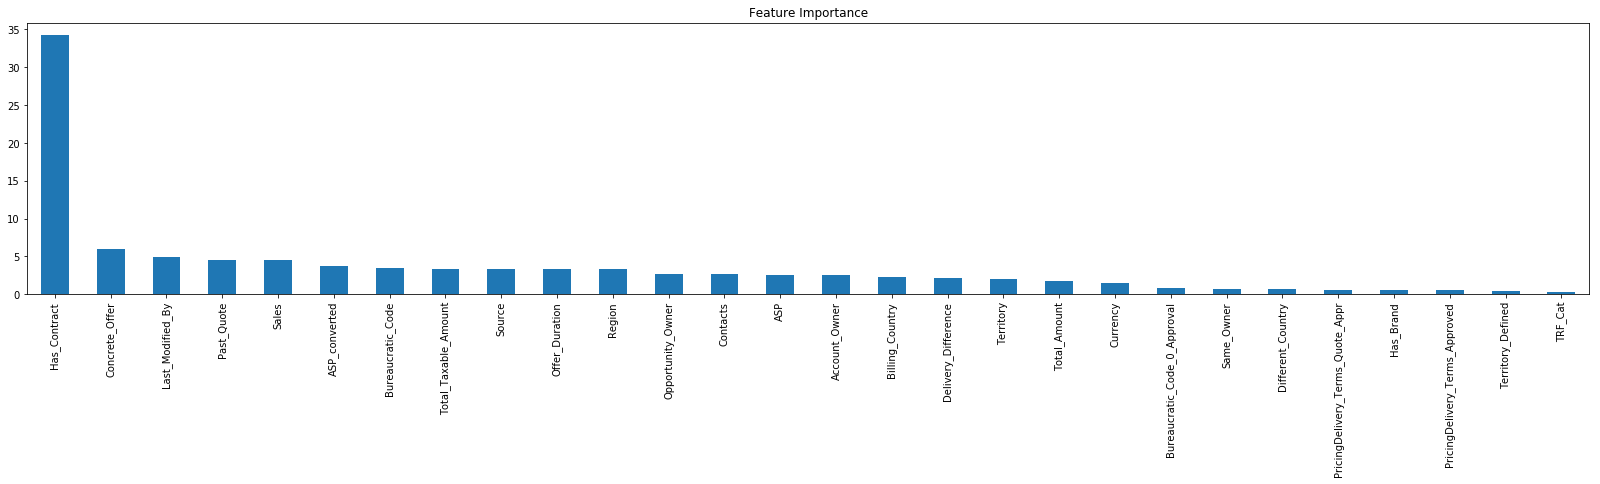

In [331]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [332]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [333]:
bad.Stage.value_counts()

0    78
1    20
Name: Stage, dtype: int64

In [334]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [341]:
prev = pd.read_csv("best/modellgbold_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9924775189488907

In [342]:
prev = pd.read_csv("best/model_xgb_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9924559493697374

In [344]:
prev = pd.read_csv("best/modelada_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9933379577636413

In [345]:
prev = pd.read_csv("best/modelcat_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9992184690592418

In [340]:
prev = pd.read_csv("best/avg_lgb_xgb_ada_cat.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9970132140445982

In [ ]:
#answer.to_csv("acceptable/submission_29.csv", header = False, index = False)